# **Sentimen Analisis Produk Review E-Commerce**



# Import Library

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# tokenizer
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
import string

from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

# Model
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Import Data

In [ ]:
!gdown 18pZrFW-pBr6k7WJn8oPbtgQKjD13g4Sg

Downloading...
From: https://drive.google.com/uc?id=18pZrFW-pBr6k7WJn8oPbtgQKjD13g4Sg
To: /content/labeledReview.datasetFix.csv
100% 2.58M/2.58M [00:00<00:00, 226MB/s]


In [ ]:
df = pd.read_csv('/content/labeledReview.datasetFix.csv')
df.head()

,review,sentimen,translate
0,Suara dan mic puas. Hanya saya pesan yg nyala ...,0,sound and mic satisfied. I only ordered the on...
1,Good. Mudah-mudahan awet. Makasih,1,good. hopefully durable. Thanks
2,"kondisi dus robek2, tolong di perhatikan lagi",0,"the condition of the box is torn, please pay a..."
3,Kualitas produk baik. Harga terjangkau dan pen...,0,product quality is good. affordable prices and...
4,"Overall bagus, tombol berfungsi semuanya, tapi...",0,"overall is good, the buttons all work, but the..."


In [ ]:
df = df.loc[:, ['translate', 'sentimen']]

In [ ]:
# Menghapus baris dengan kolom content null dan menghapus duplikasi
df = df.dropna(subset=['translate']).drop_duplicates()

In [ ]:
# Mengubah nama kolom translate jd review
df = df.rename(columns={'translate': 'review'})

# EDA

## WordCloud

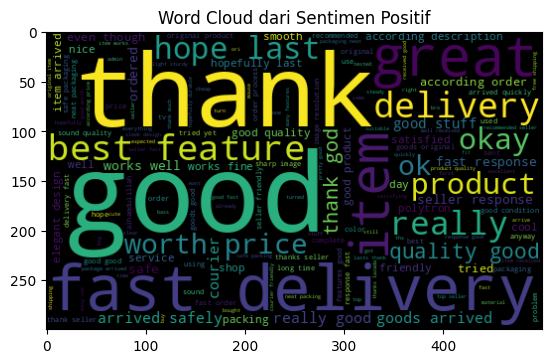

In [ ]:
df_positif = df[df['sentimen'] == 1]
all_words_positif = ' '.join([twts for twts in df_positif['review']])
wordcloud_positif = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_positif)

plt.imshow(wordcloud_positif, interpolation="bilinear")
# plt.axis('off')
plt.title('Word Cloud dari Sentimen Positif')
plt.show()

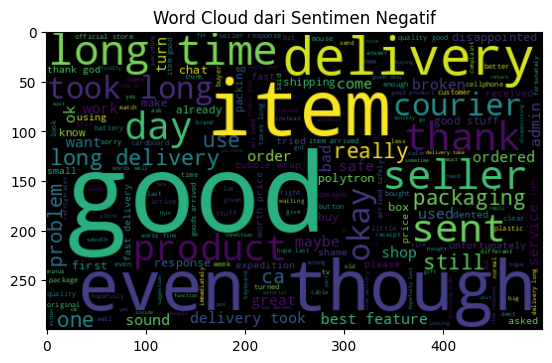

In [ ]:
df_negatif = df[df['sentimen'] == 0]
all_words_negatif = ' '.join([twts for twts in df_negatif['review']])
wordcloud_negatif = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_negatif)

plt.imshow(wordcloud_negatif, interpolation="bilinear")
# plt.axis('off')
plt.title('Word Cloud dari Sentimen Negatif')
plt.show()

## Distribusi Target

In [ ]:
temp = df.groupby('sentimen').count()['review'].reset_index()
temp['sentimen'] = temp['sentimen'].map({0: 'Negatif', 1: 'Positif'})
temp = temp.sort_values(by='review', ascending=False)
temp.style.background_gradient(cmap='inferno_r')

,sentimen,review
1,Positif,5793
0,Negatif,5792


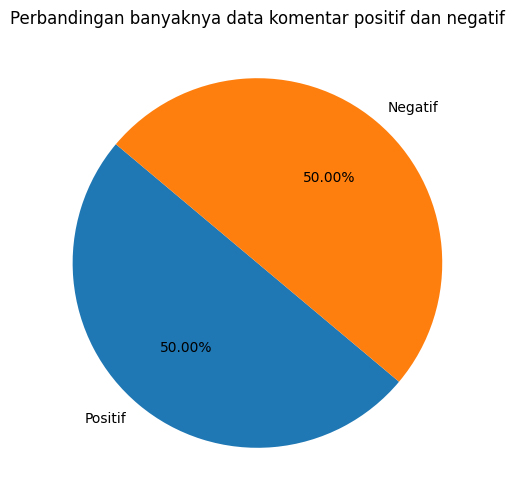

In [ ]:
plt.figure(figsize=(8,6))
plt.pie(temp['review'], labels= temp['sentimen'], autopct='%1.2f%%', startangle=140)
plt.title('Perbandingan banyaknya data komentar positif dan negatif')
plt.show()

In [ ]:
from os import replace
# Menghapus stopwords, mengubah huruf menjadi kecil, dan tokenisasi
stop_words = stopwords.words('english')
df['review'] = df['review'].apply(lambda x: [word.lower() for word in word_tokenize(x) if (word.isalpha() and word.lower() not in stop_words)])

# Normalisasi teks
df['review'] = df['review'].apply(lambda x: ' '.join(x))

df.head()

,review,sentimen
0,sound mic satisfied ordered one made sure clic...,0
1,good hopefully durable thanks,1
2,condition box torn please pay attention,0
3,product quality good affordable prices fast de...,0
4,overall good buttons work packaging lacking de...,0


# Modelling

In [ ]:
X = df['review']
y = df['sentimen']

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=25, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=25, stratify=y_val
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 9268
Validation set size: 1158
Testing set size: 1159


In [ ]:
# Inisialisasi tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenisasi data
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize_function(X_train)
val_encodings = tokenize_function(X_val)
test_encodings = tokenize_function(X_test)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

class ReviewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = ReviewsDataset(train_encodings, y_train.tolist())
val_dataset = ReviewsDataset(val_encodings, y_val.tolist())
test_dataset = ReviewsDataset(test_encodings, y_test.tolist())

In [ ]:
# Inisialisasi model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Negatif dan Positif
    output_attentions=False,
    output_hidden_states=False
)

# Pendefinisian training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # Jumlah training epochs
    per_device_train_batch_size=16,  # Ukuran batch untuk training
    per_device_eval_batch_size=64,   # Ukuran batch untuk evaluasi
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    eval_strategy='epoch',
    save_strategy='epoch'
)

# Pendefinisian komputasi metrik
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Inisialisasi trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nadirae25 (nadirae25-university-of-indonesia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.186100,0.211327,0.927461,0.927461,0.927466,0.927461
2,0.159800,0.205366,0.937824,0.937757,0.939718,0.937824
3,0.019000,0.238807,0.943869,0.943859,0.944167,0.943869


TrainOutput(global_step=1740, training_loss=0.19551581208990224, metrics={'train_runtime': 670.4264, 'train_samples_per_second': 41.472, 'train_steps_per_second': 2.595, 'total_flos': 1828884945807360.0, 'train_loss': 0.19551581208990224, 'epoch': 3.0})

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.93      0.95      0.94       579
     Positif       0.95      0.92      0.94       580

    accuracy                           0.94      1159
   macro avg       0.94      0.94      0.94      1159
weighted avg       0.94      0.94      0.94      1159



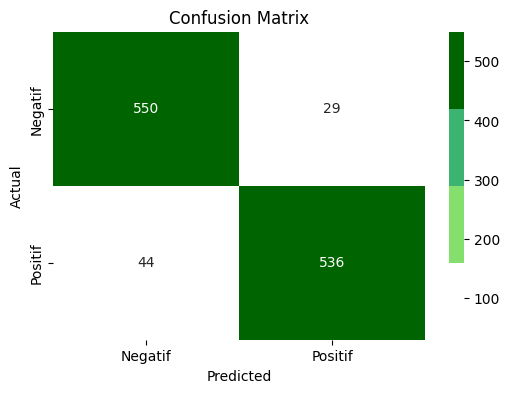

Accuracy: 93.70%


In [ ]:
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Prediksi
predictions, true_labels, _ = trainer.predict(test_dataset)
preds = np.argmax(predictions, axis=1)

print("Classification Report:")
print(classification_report(y_test, preds, target_names=['Negatif', 'Positif']))

# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))

cmap = mcolors.ListedColormap(['#ffffff', '#85df6d', '#3cb371', '#006400'])  # White to light green to dark green

sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
            xticklabels=['Negatif', 'Positif'],
            yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Akurasi
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy * 100:.2f}%")